U ovom projektu razmotrićemo skup podataka koji predstavlja upotrebu električne energije u domaćinstvu.\
Prvo ćemo analizirati skup podataka, vizuelizovati i zatim trenirati par modela za predviđanje upotrebe energije.\
Nakon toga ćemo primenom obrađenih metoda u radu pokušati da poboljšamo performanse regularizacijom, otklanjanjem šuma i uklanjanjem outliera.

## Uvoz podataka i konverzija

In [63]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import random

In [64]:
data = pd.read_csv('./data/household_power/household_power_consumption.csv')

C:\Users\Danilo\AppData\Local\Temp\ipykernel_12172\2745776467.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/household_power/household_power_consumption.csv')


Na osnovu narednih analiza možemo videti da skup podataka čine numeričke vrednosti izuzev datuma i vremena.\
Međutim, ove numeričke vrednosti su pročitane kao object.
Zato ćemo
- Datum i vreme pretvoriti u timestamp
- Ostale atribute pretvoriti u float16

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [66]:
data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [67]:
initial_date_str = "16/12/2006 17:24:00"
initial_date = datetime.strptime(initial_date_str, "%d/%m/%Y %H:%M:%S")

data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H:%M:%S')
data['Timestamp'] = (data['Datetime'] - initial_date).dt.total_seconds()/60 # timestamp je u minutima

In [68]:
data.drop(columns=['Date', 'Time', 'Datetime'], axis=1, inplace=True)
timestamps = data['Timestamp']

In [69]:
data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Timestamp
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,0.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,1.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,3.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,4.0
...,...,...,...,...,...,...,...,...
2075254,0.946,0.0,240.43,4.0,0.0,0.0,0.0,2075254.0
2075255,0.944,0.0,240.0,4.0,0.0,0.0,0.0,2075255.0
2075256,0.938,0.0,239.82,3.8,0.0,0.0,0.0,2075256.0
2075257,0.934,0.0,239.7,3.8,0.0,0.0,0.0,2075257.0


In [70]:
data = data.apply(pd.to_numeric, errors='coerce').astype('float16')
data['Timestamp'] = timestamps

c:\Users\Danilo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [71]:
data

c:\Users\Danilo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Timestamp
0,4.214844,0.417969,234.875,18.406250,0.0,1.0,17.0,0.0
1,5.359375,0.436035,233.625,23.000000,0.0,1.0,16.0,1.0
2,5.375000,0.498047,233.250,23.000000,0.0,2.0,17.0,2.0
3,5.386719,0.501953,233.750,23.000000,0.0,1.0,17.0,3.0
4,3.666016,0.527832,235.625,15.796875,0.0,1.0,17.0,4.0
...,...,...,...,...,...,...,...,...
2075254,0.945801,0.000000,240.375,4.000000,0.0,0.0,0.0,2075254.0
2075255,0.943848,0.000000,240.000,4.000000,0.0,0.0,0.0,2075255.0
2075256,0.937988,0.000000,239.875,3.800781,0.0,0.0,0.0,2075256.0
2075257,0.934082,0.000000,239.750,3.800781,0.0,0.0,0.0,2075257.0


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float16
 1   Global_reactive_power  float16
 2   Voltage                float16
 3   Global_intensity       float16
 4   Sub_metering_1         float16
 5   Sub_metering_2         float16
 6   Sub_metering_3         float16
 7   Timestamp              float64
dtypes: float16(7), float64(1)
memory usage: 43.5 MB


Sada imamo skup podataka sa isključivo numeričkim podacima i timestamp-om.

## Vizuelizacija podataka

In [73]:
def plot_timeseries(df, timestamp_column, columns = None, minute_limit=None):
    def random_color():
        return (random.random(), random.random(), random.random())
    dataColumns = columns if columns is not None else df.columns
    localDf = df if minute_limit is None else df.head(minute_limit)
    for column in dataColumns:
        if column == timestamp_column:
            continue
        plt.figure(figsize=(30, 8))
        plt.plot(localDf[timestamp_column], localDf[column], label = column, color=random_color())
        plt.xlabel('Timestamp (minutes)')
        plt.ylabel('Values')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

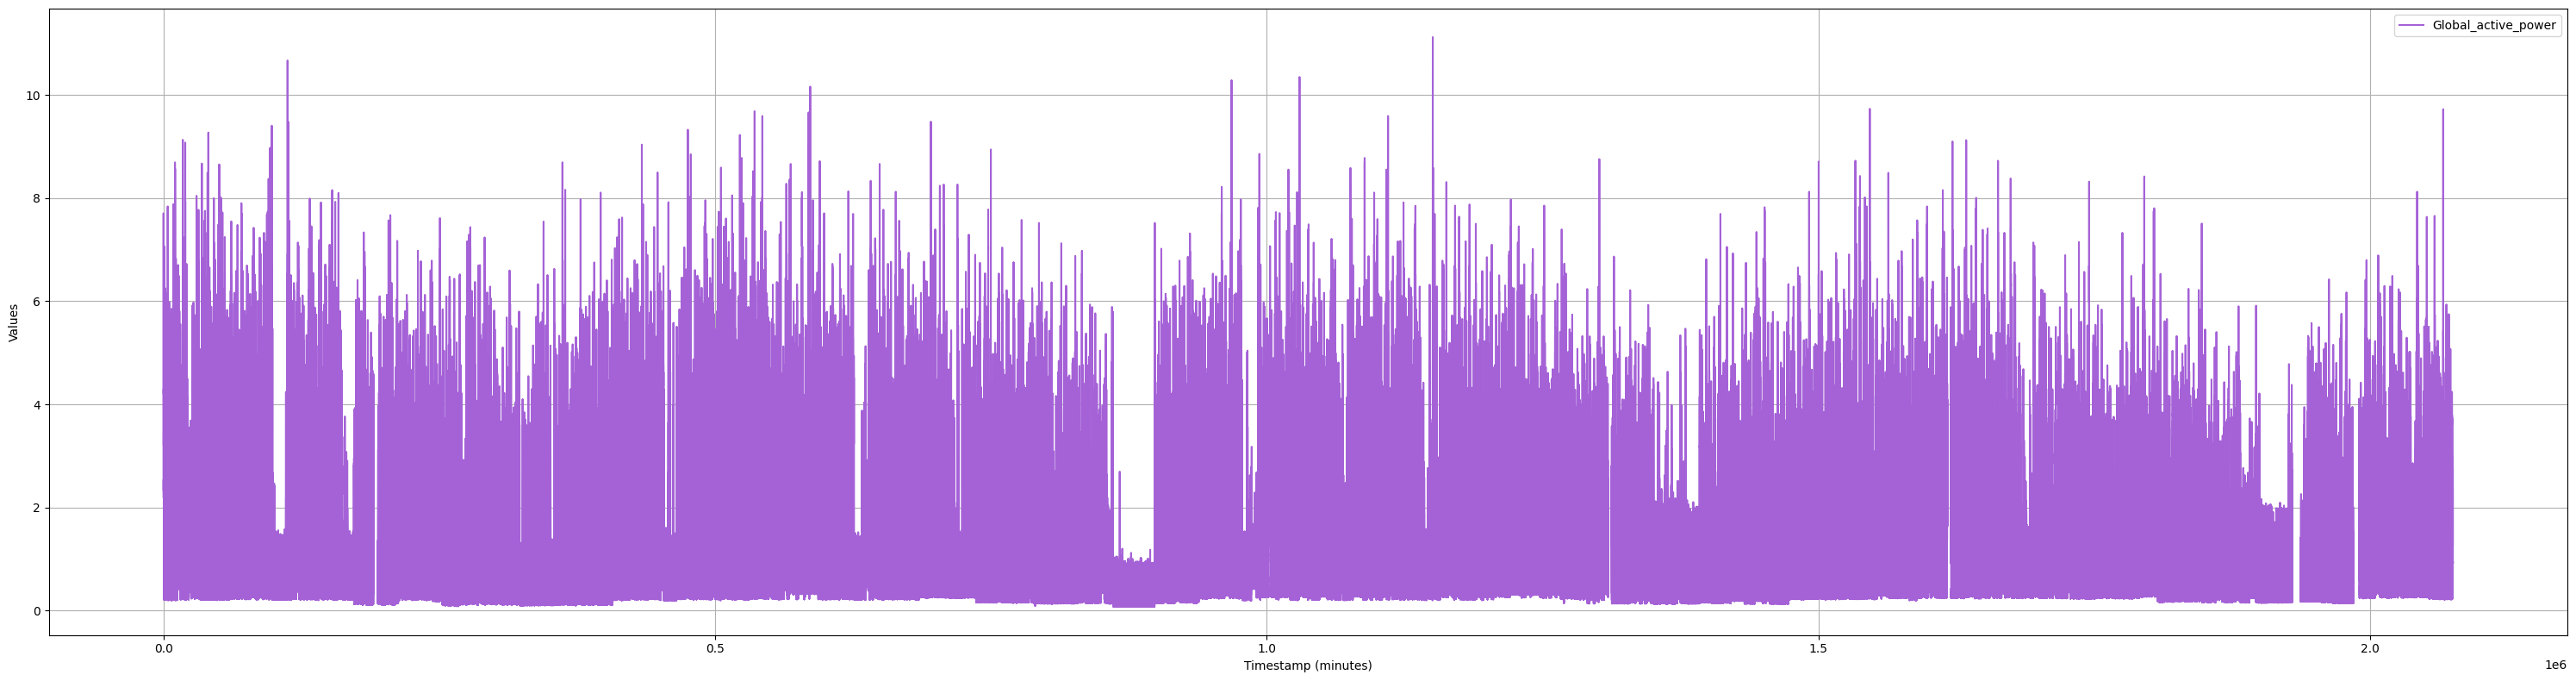

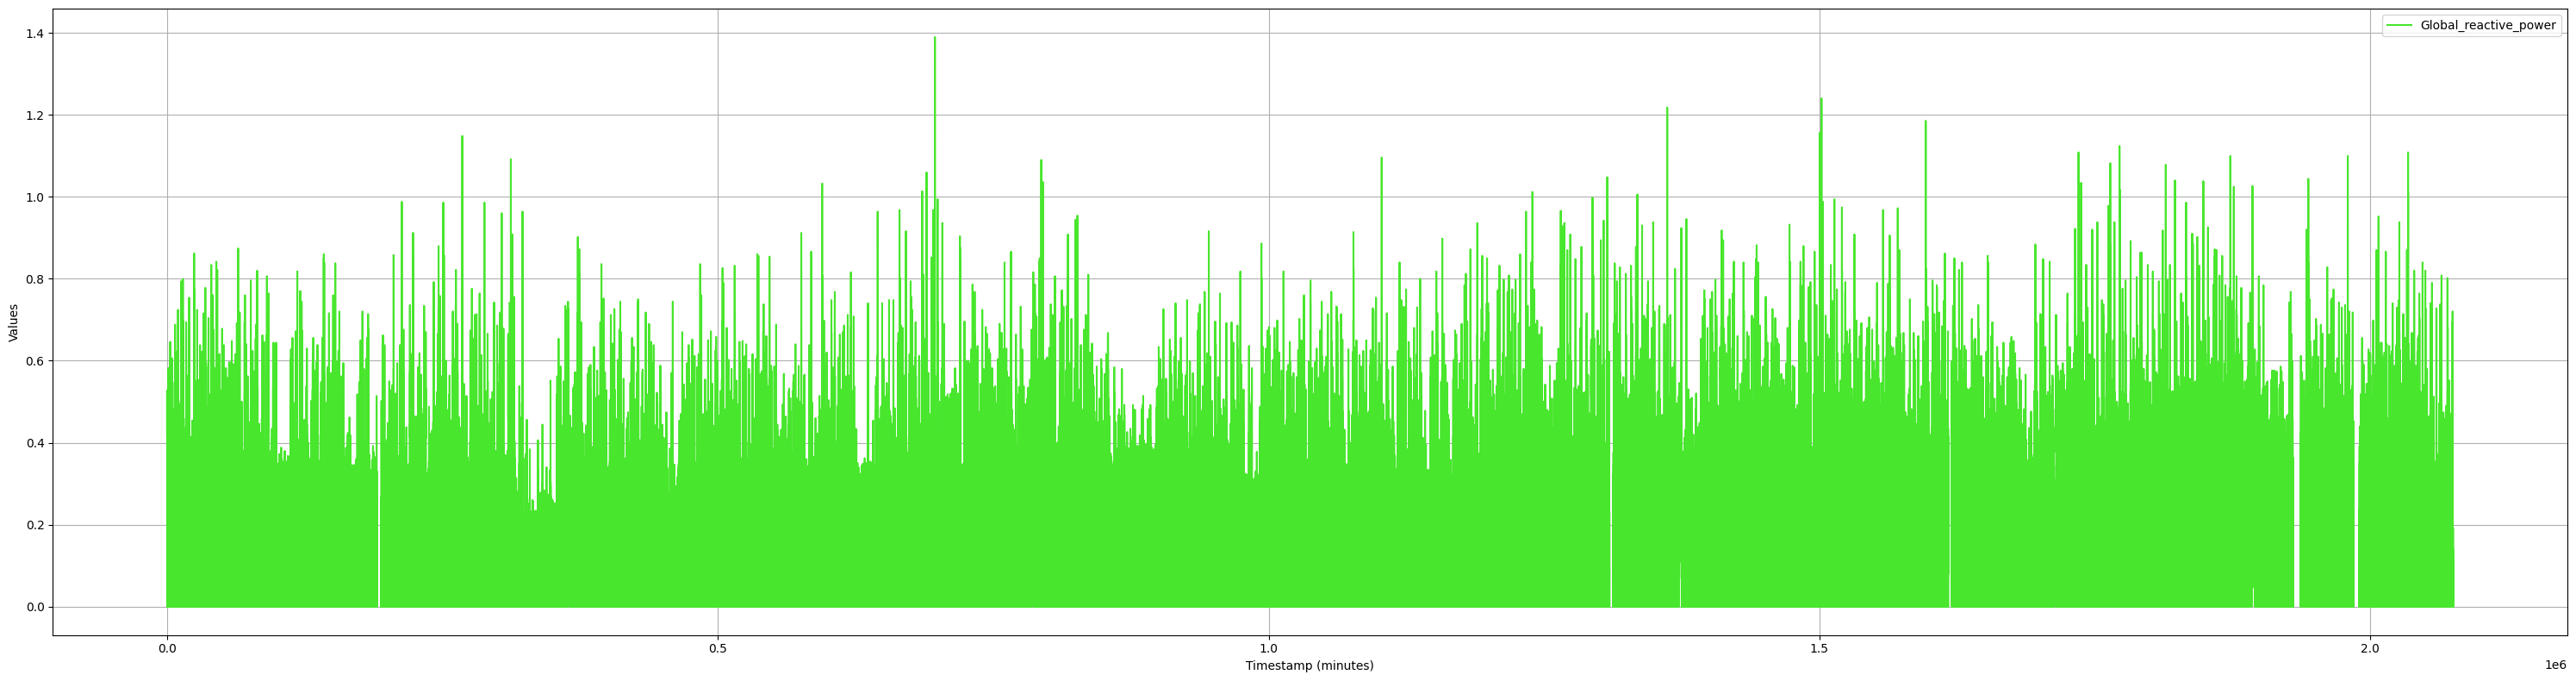

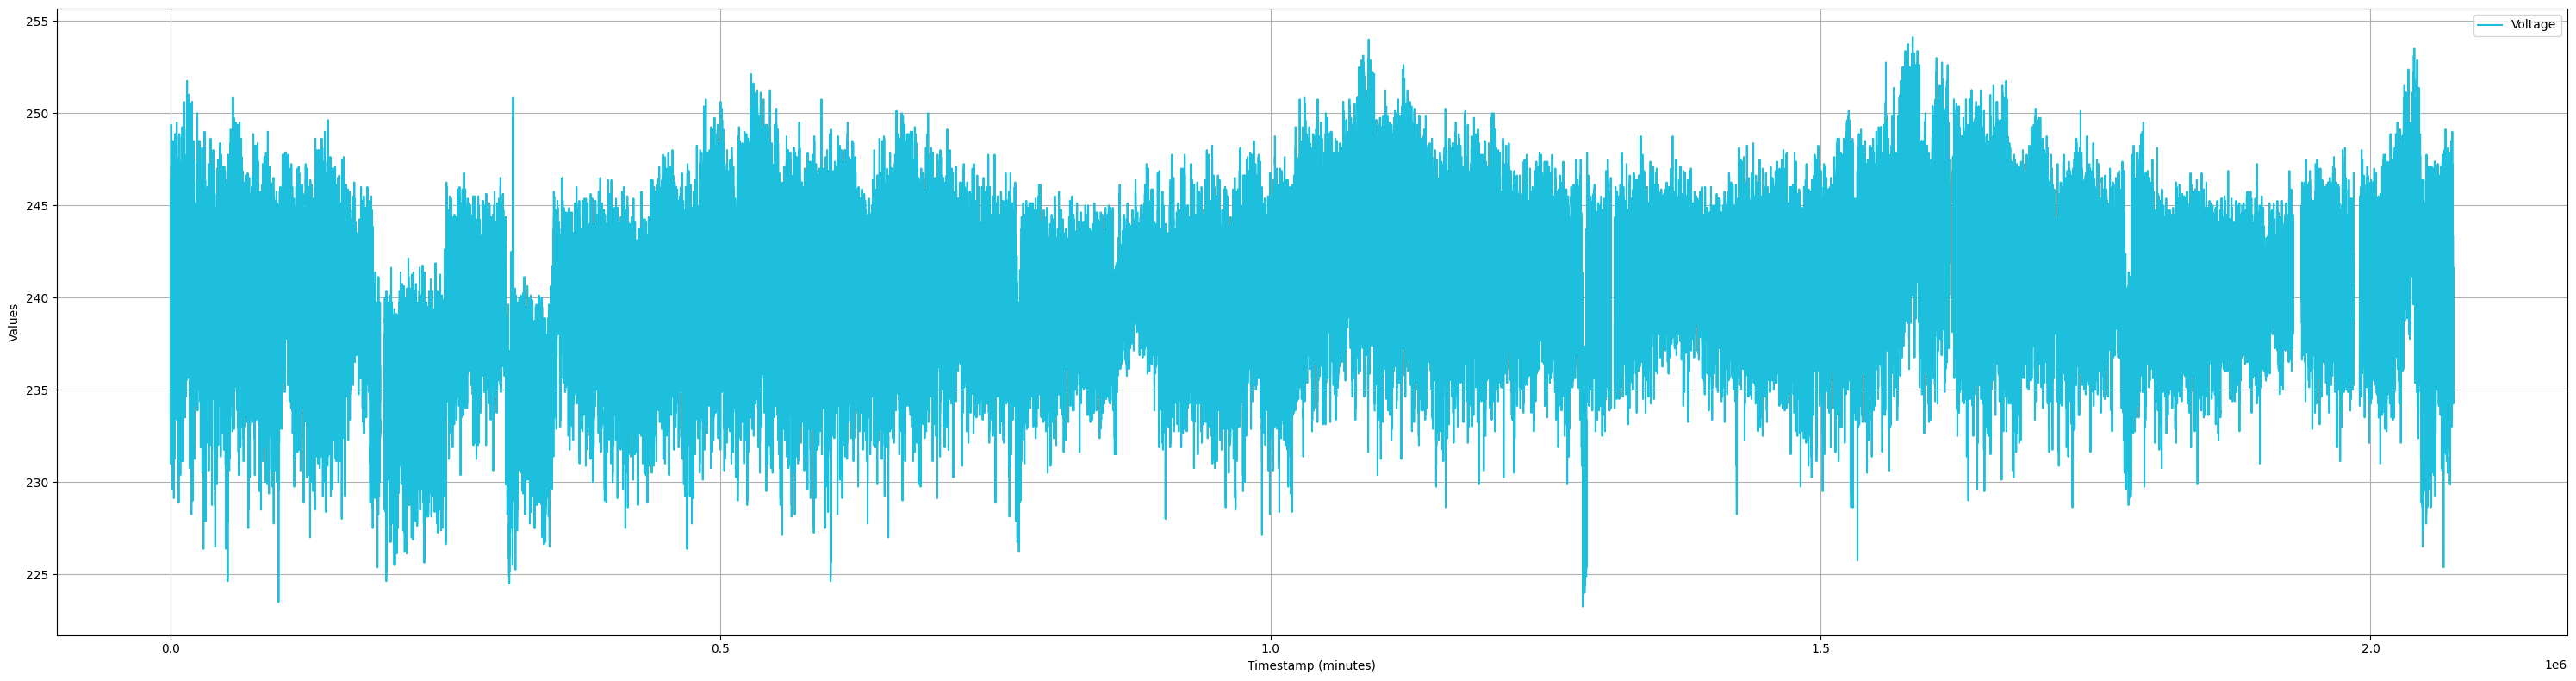

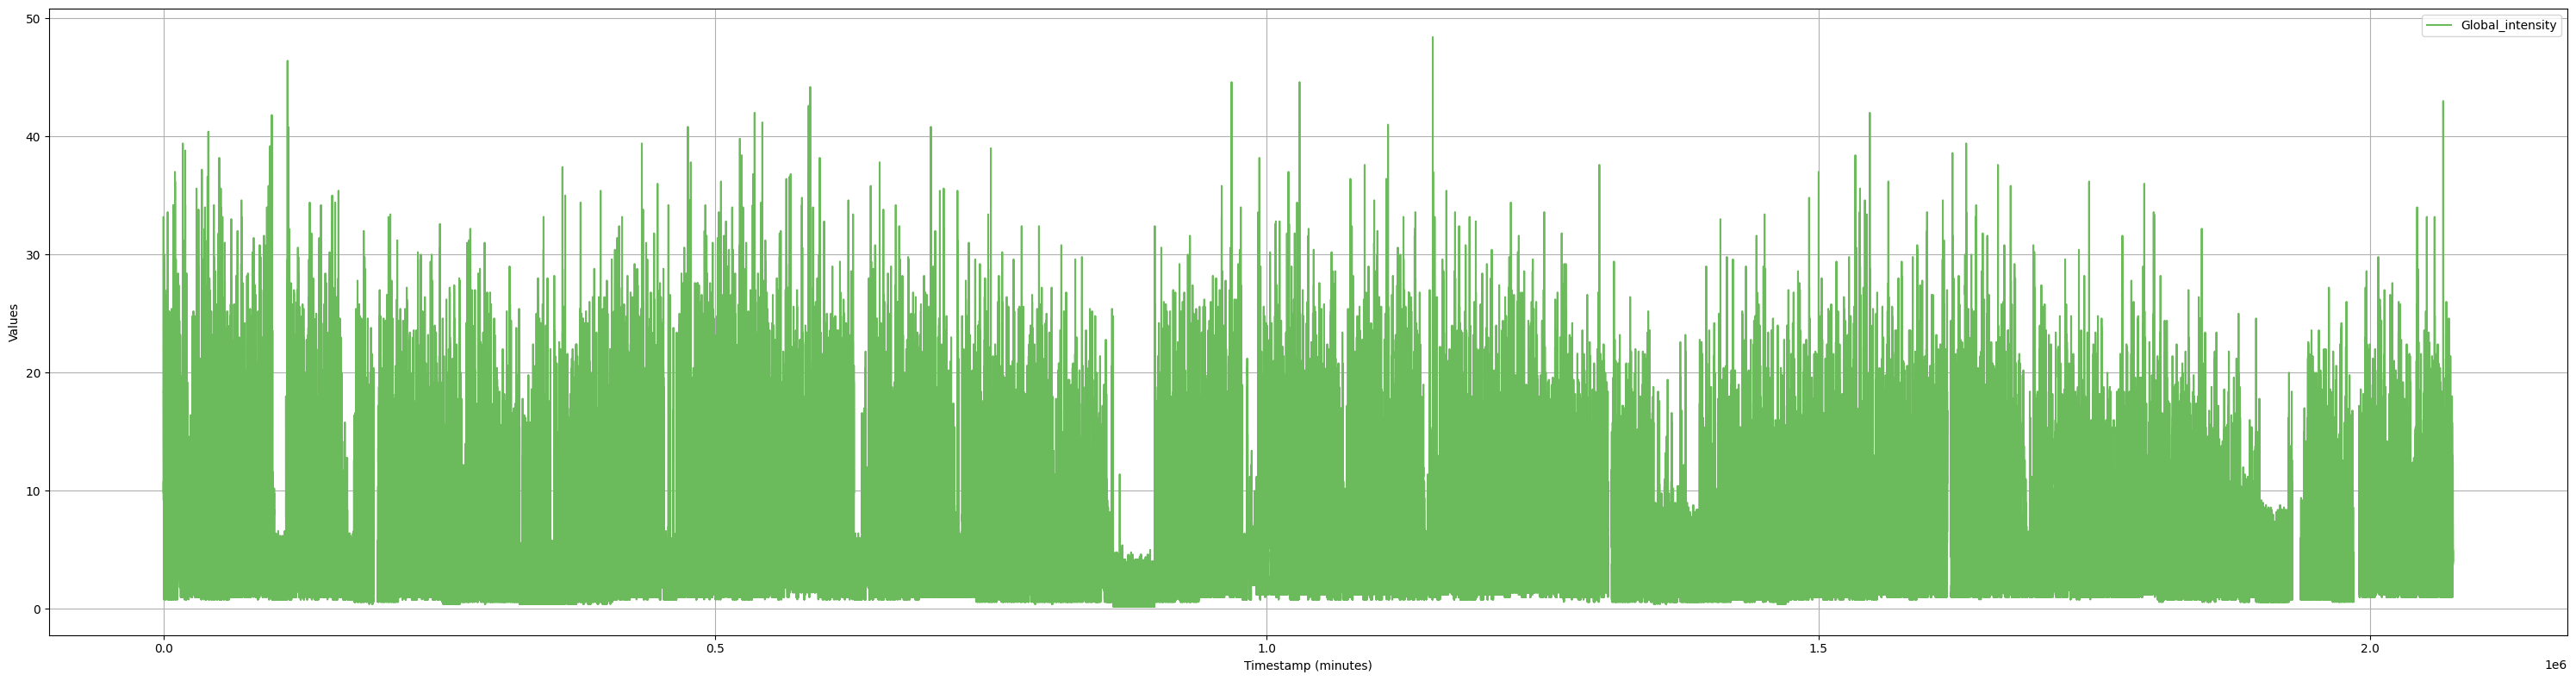

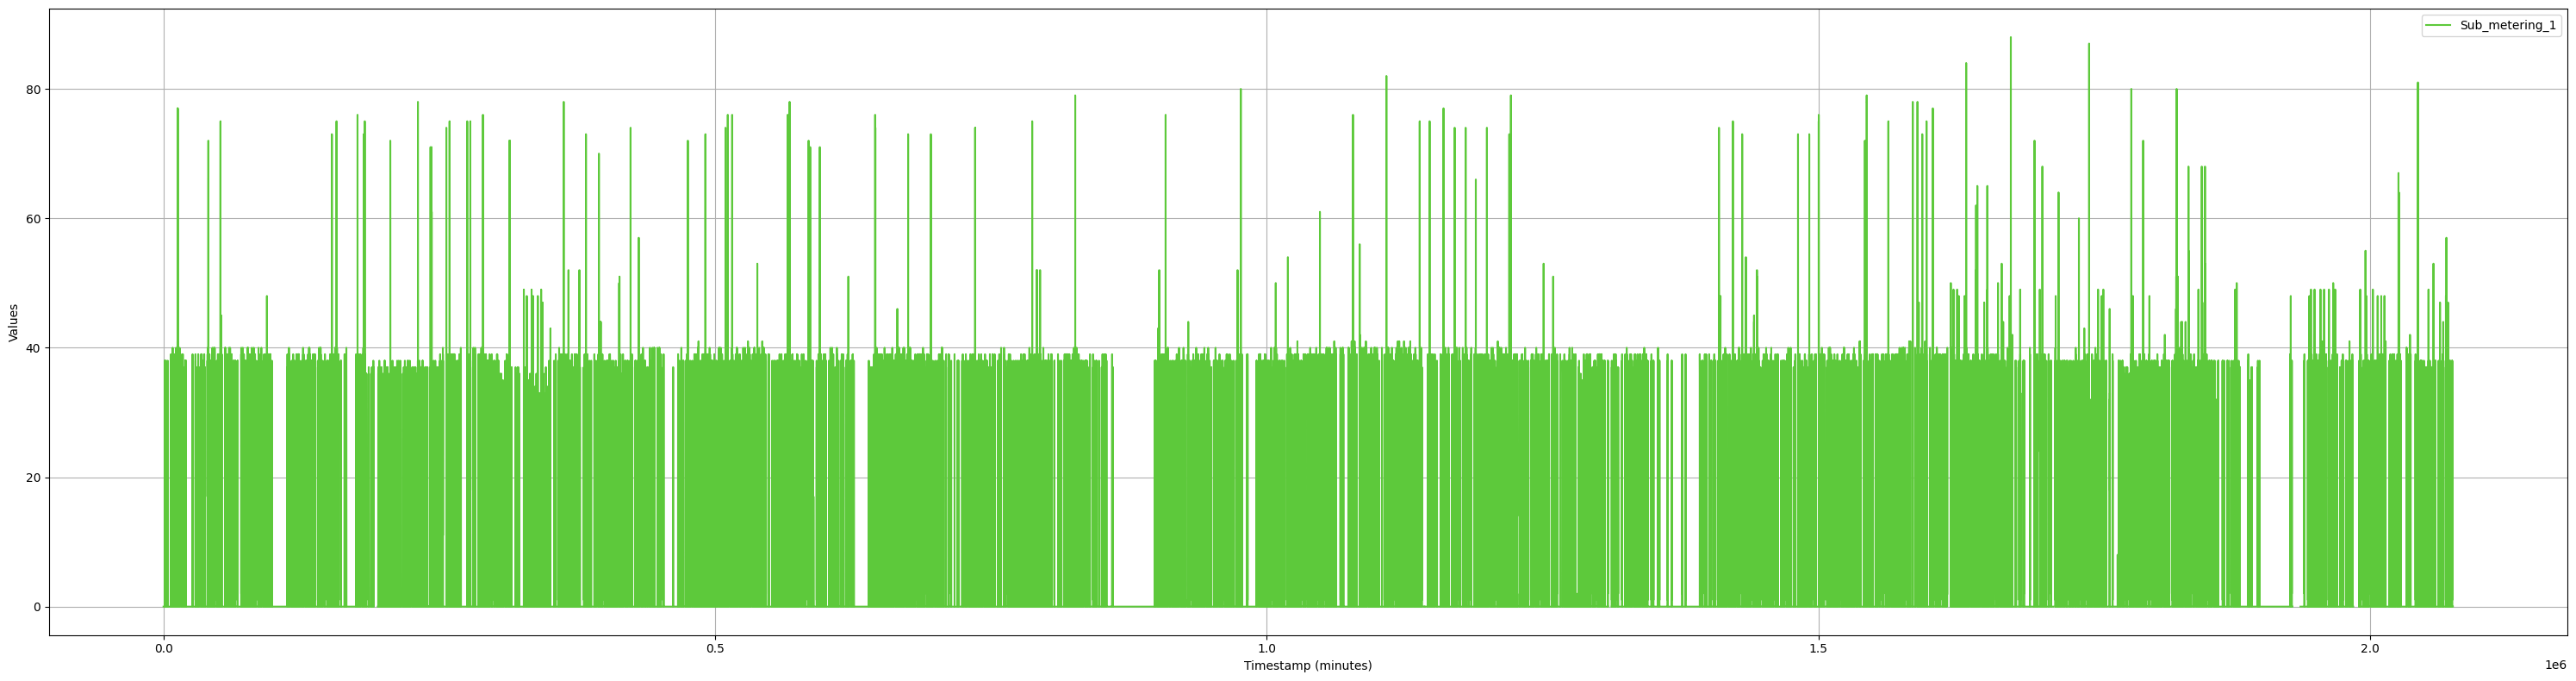

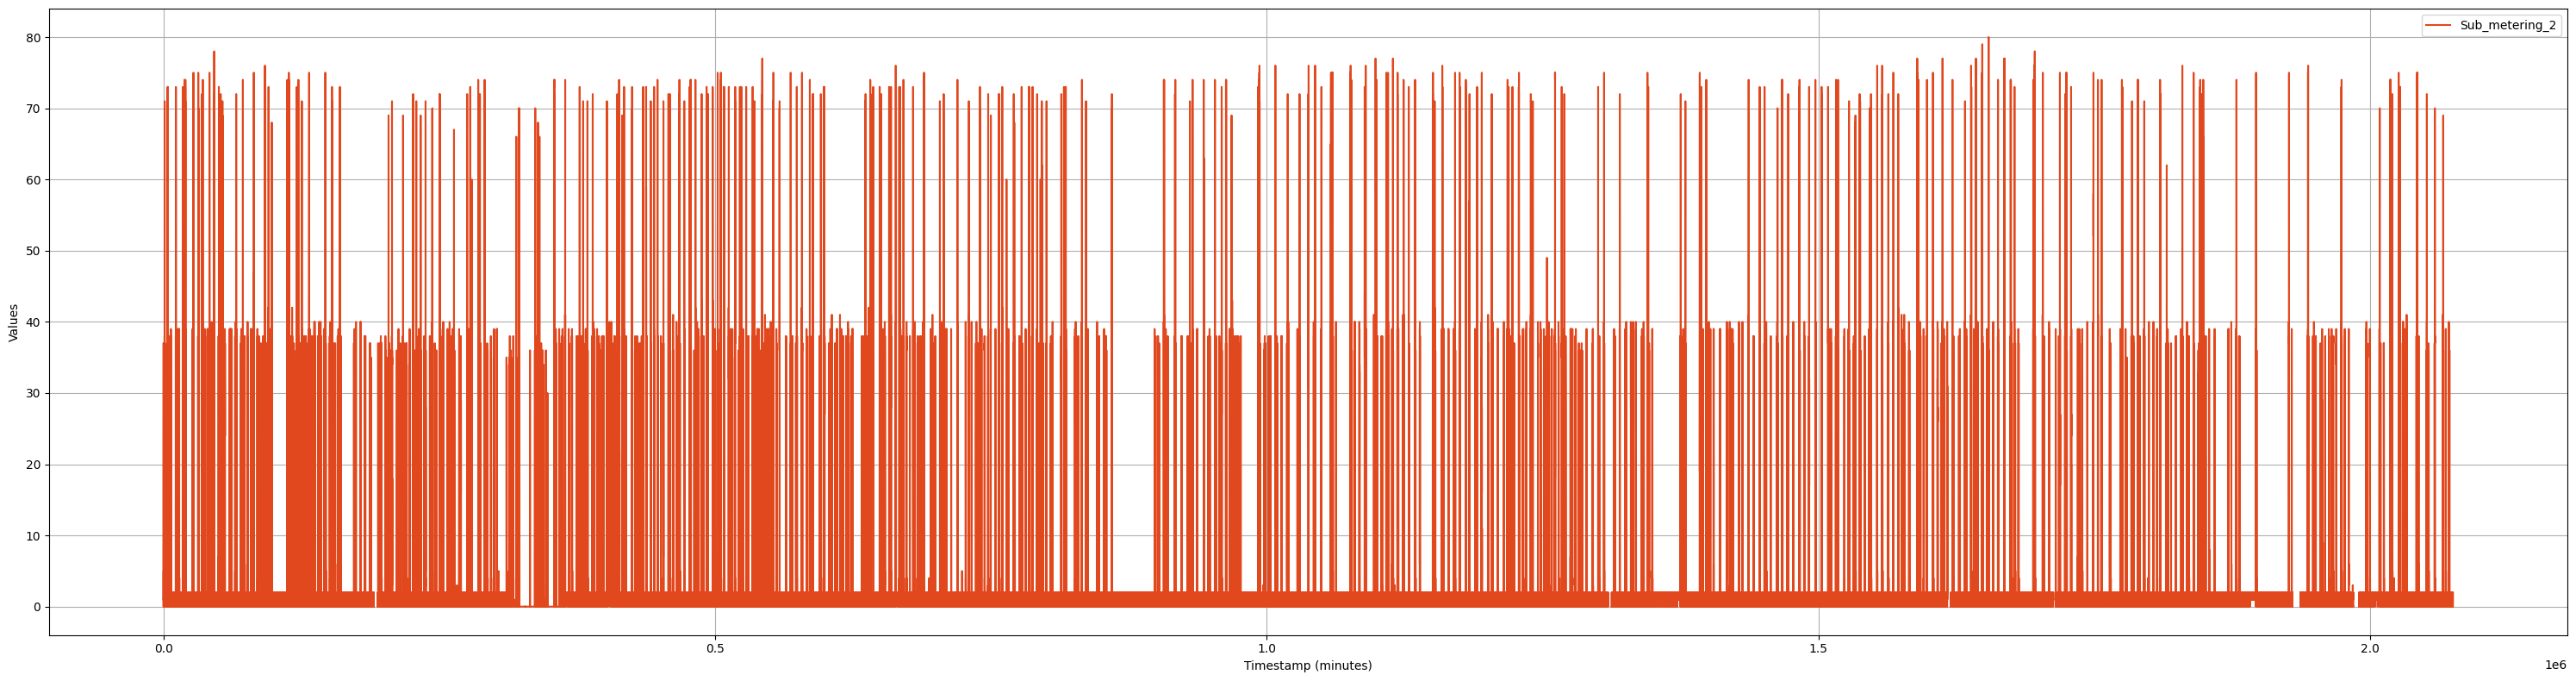

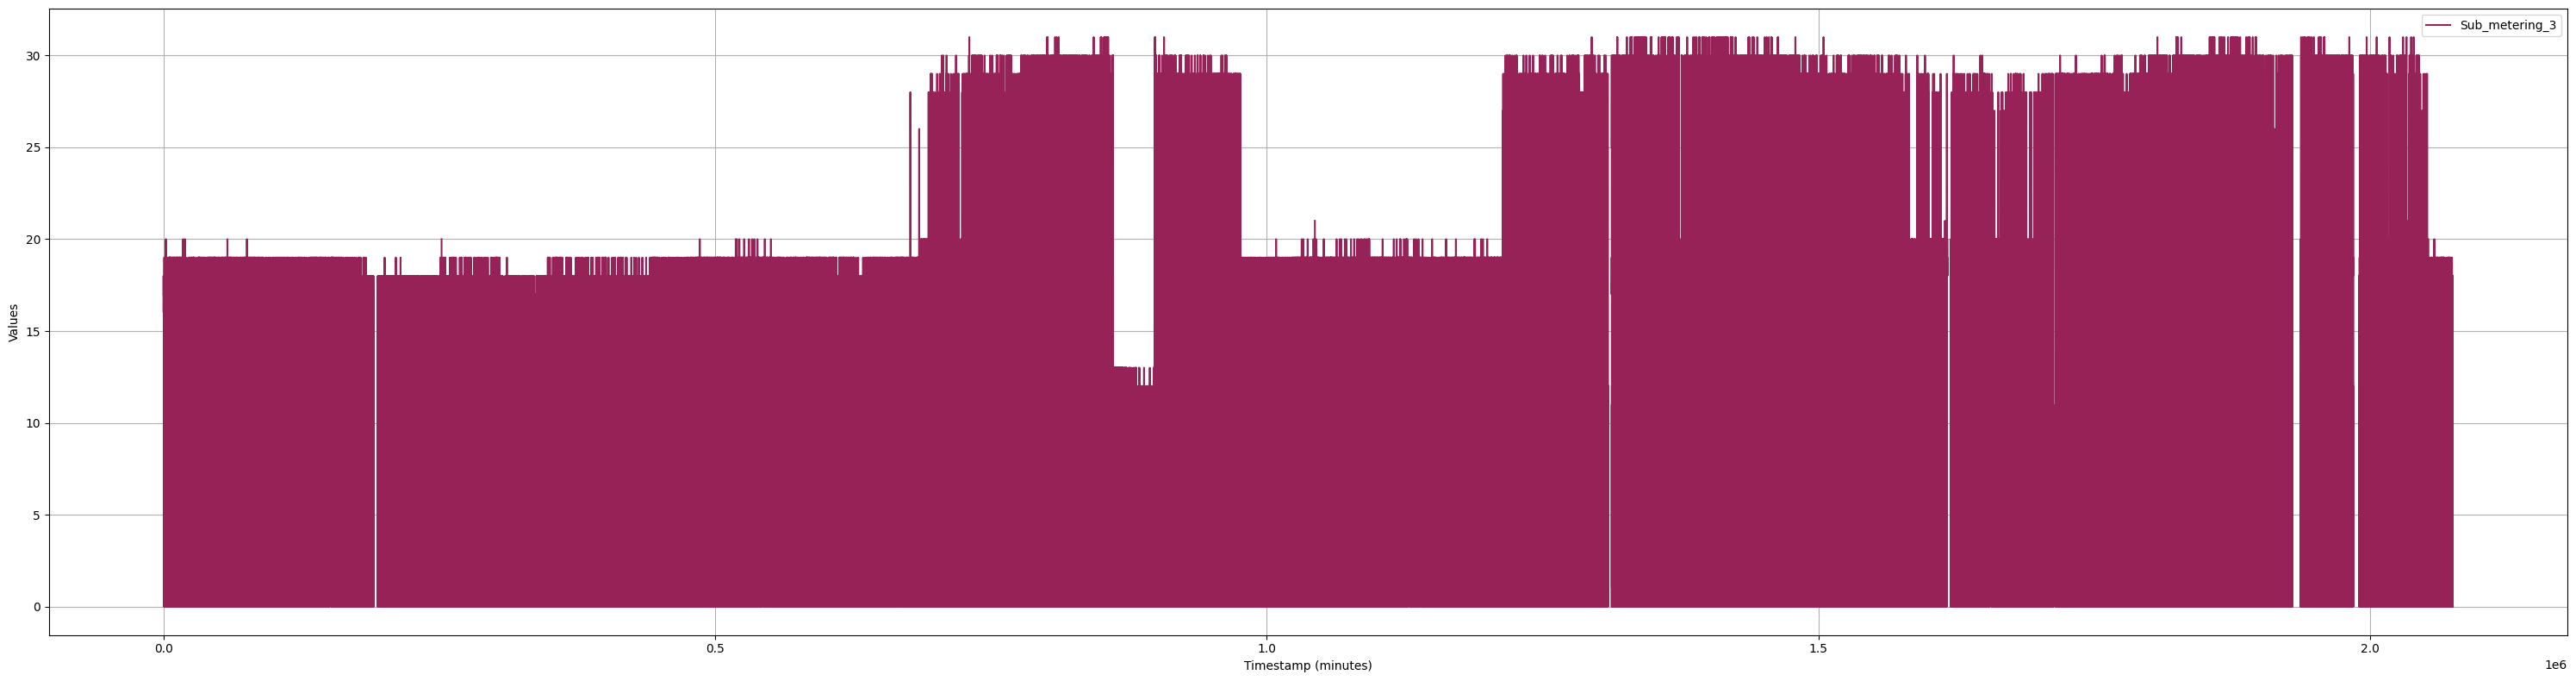

In [74]:
plot_timeseries(data, 'Timestamp', minute_limit=None)

Teško je primetiti detalje u signalu s obzirom da imamo puno unosa u skupu. Zato ćemo ograničiti prikaz na prvih 10000 minuta.

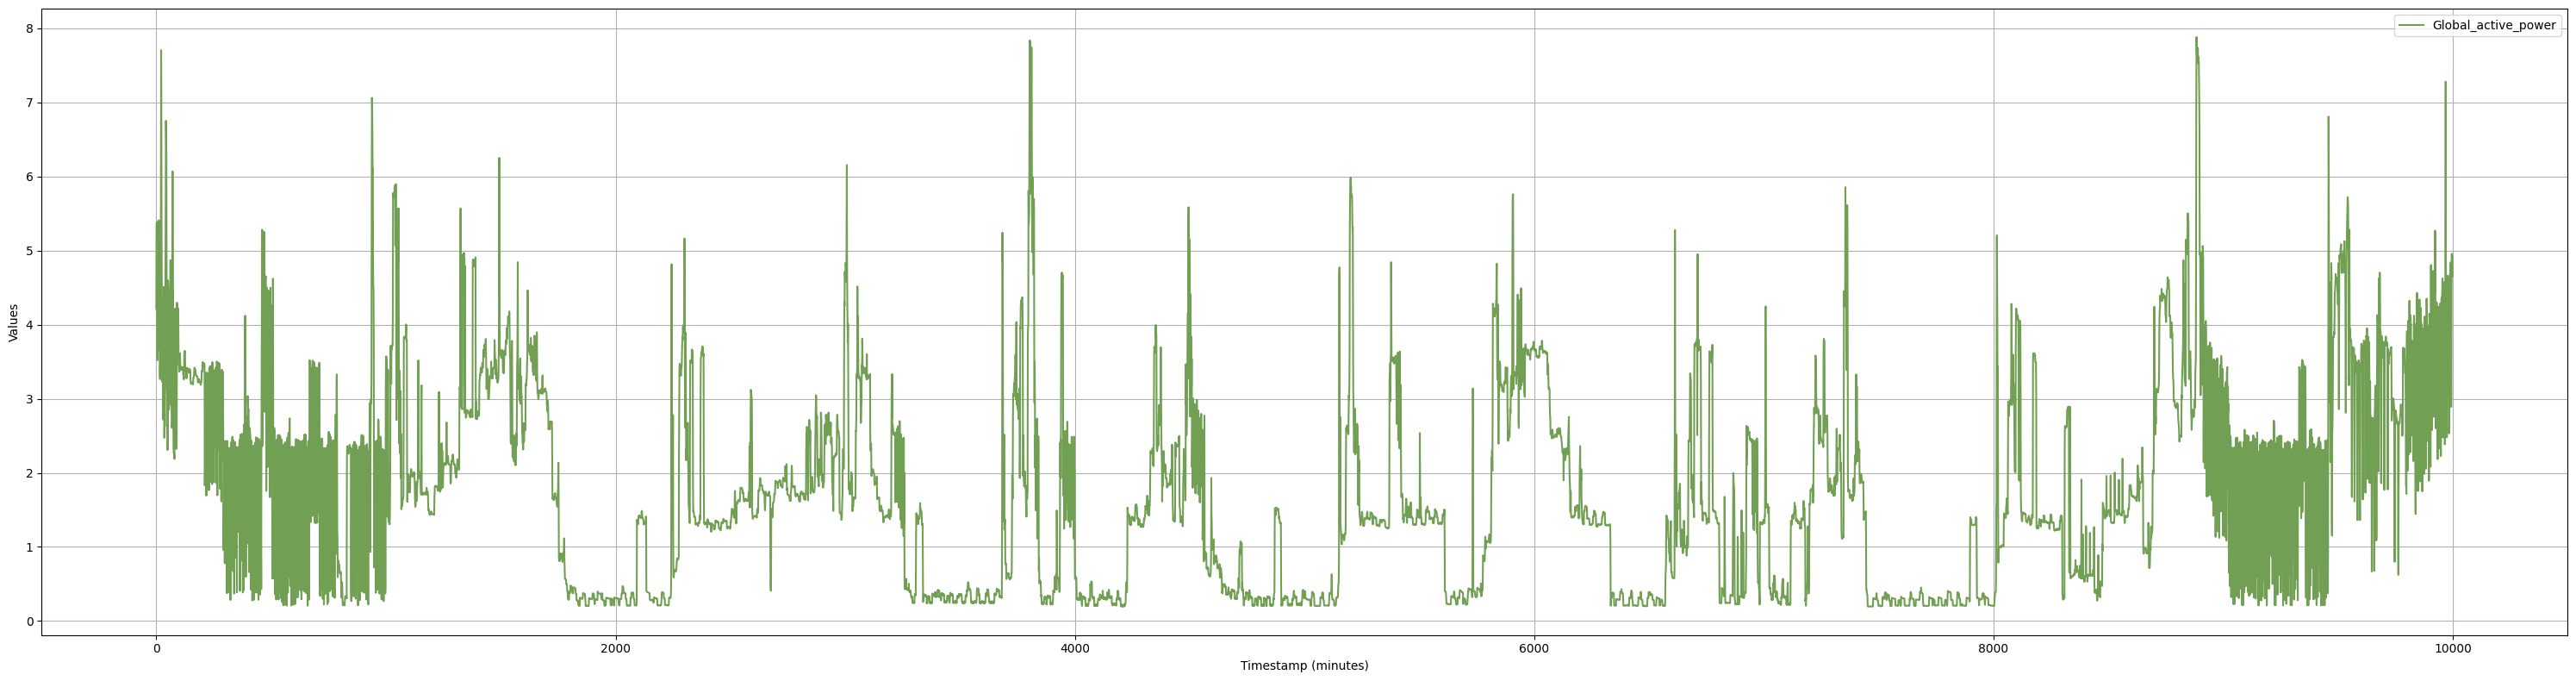

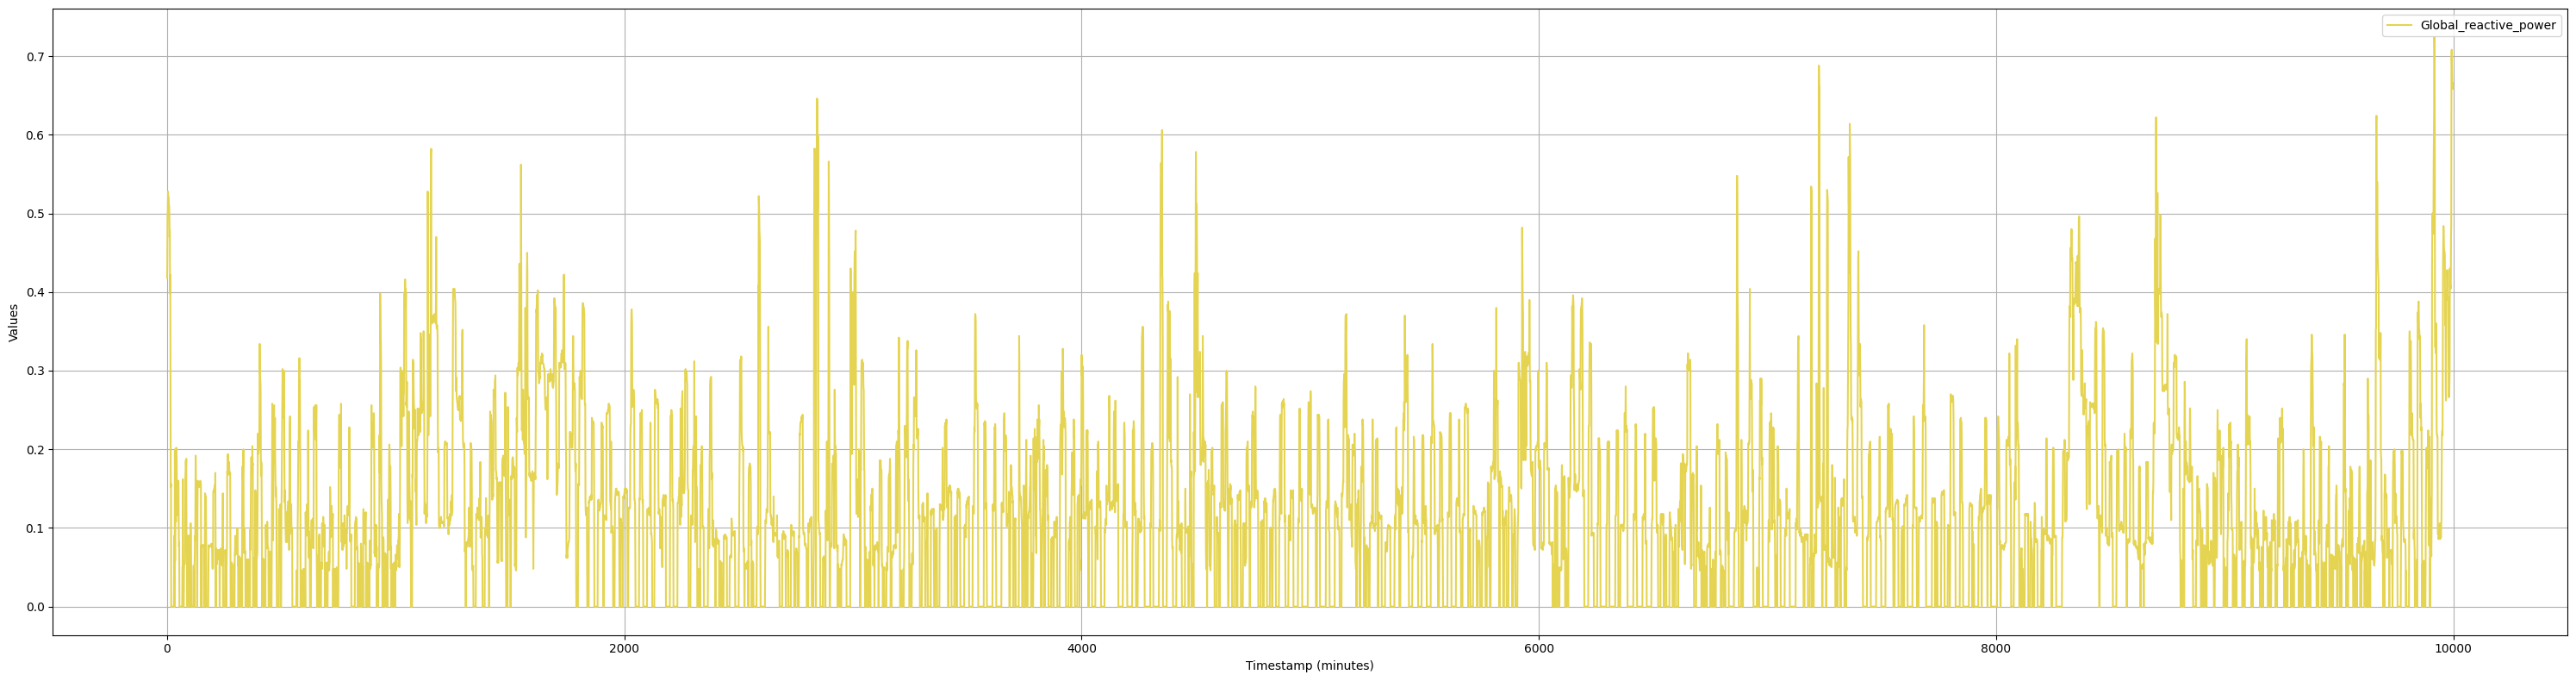

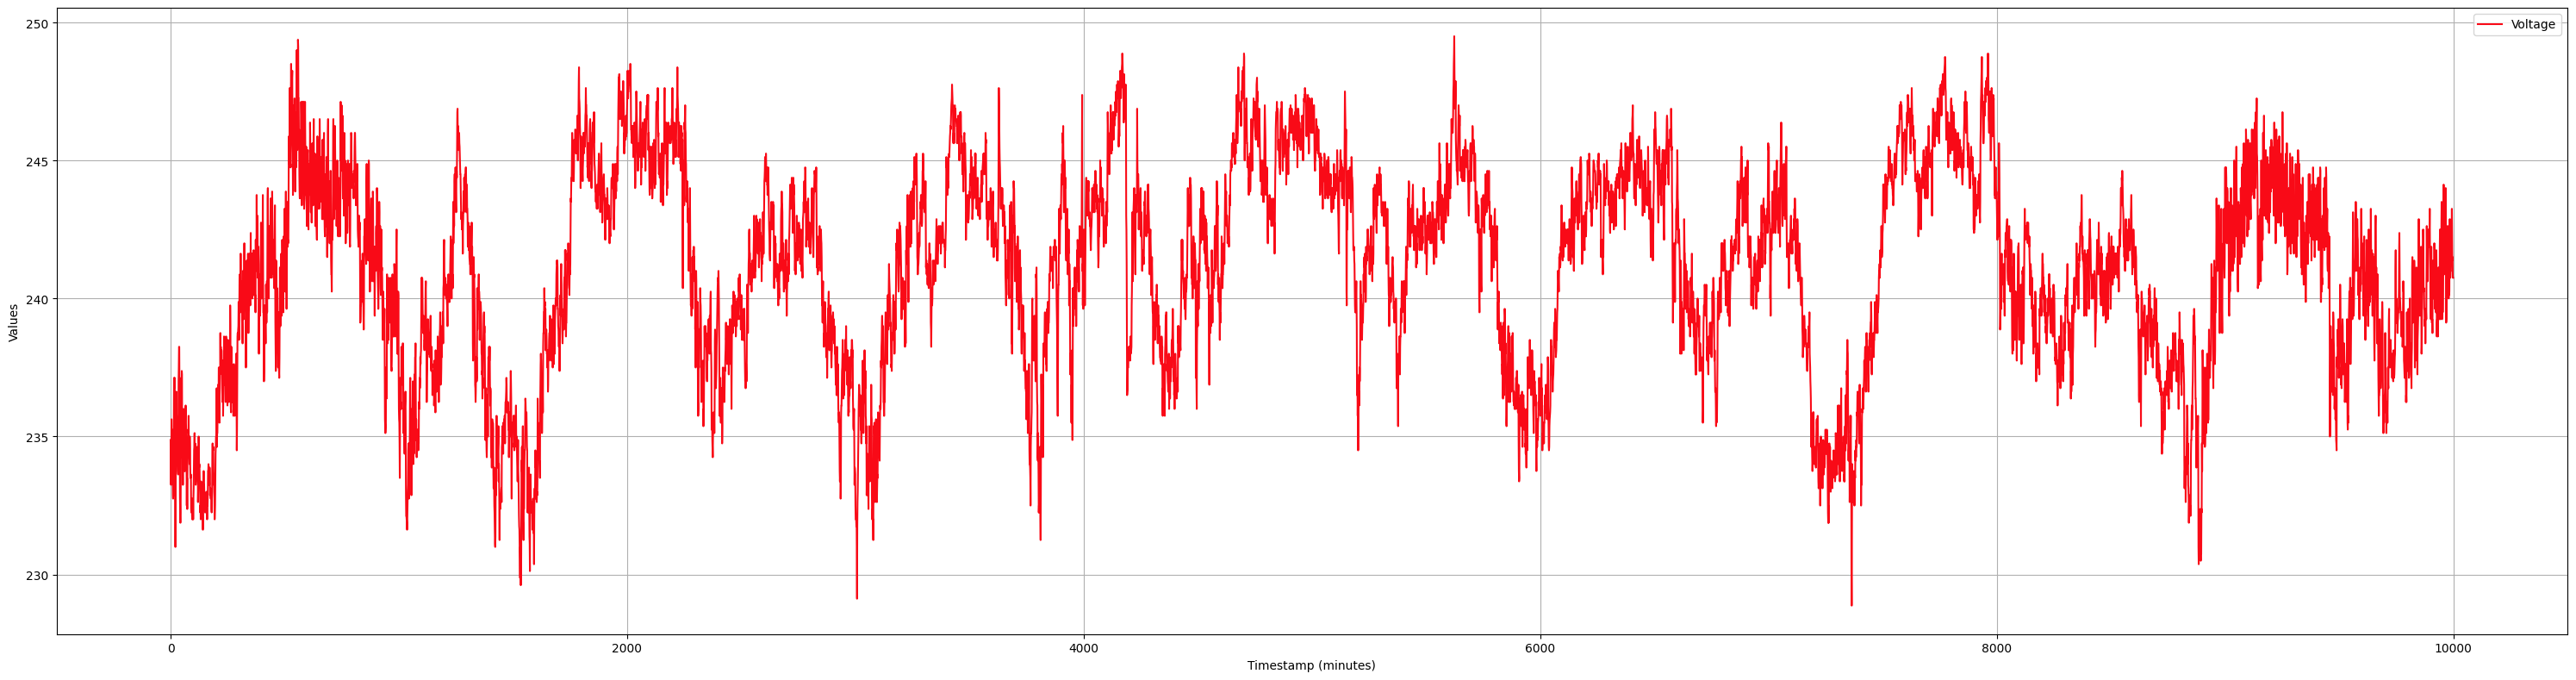

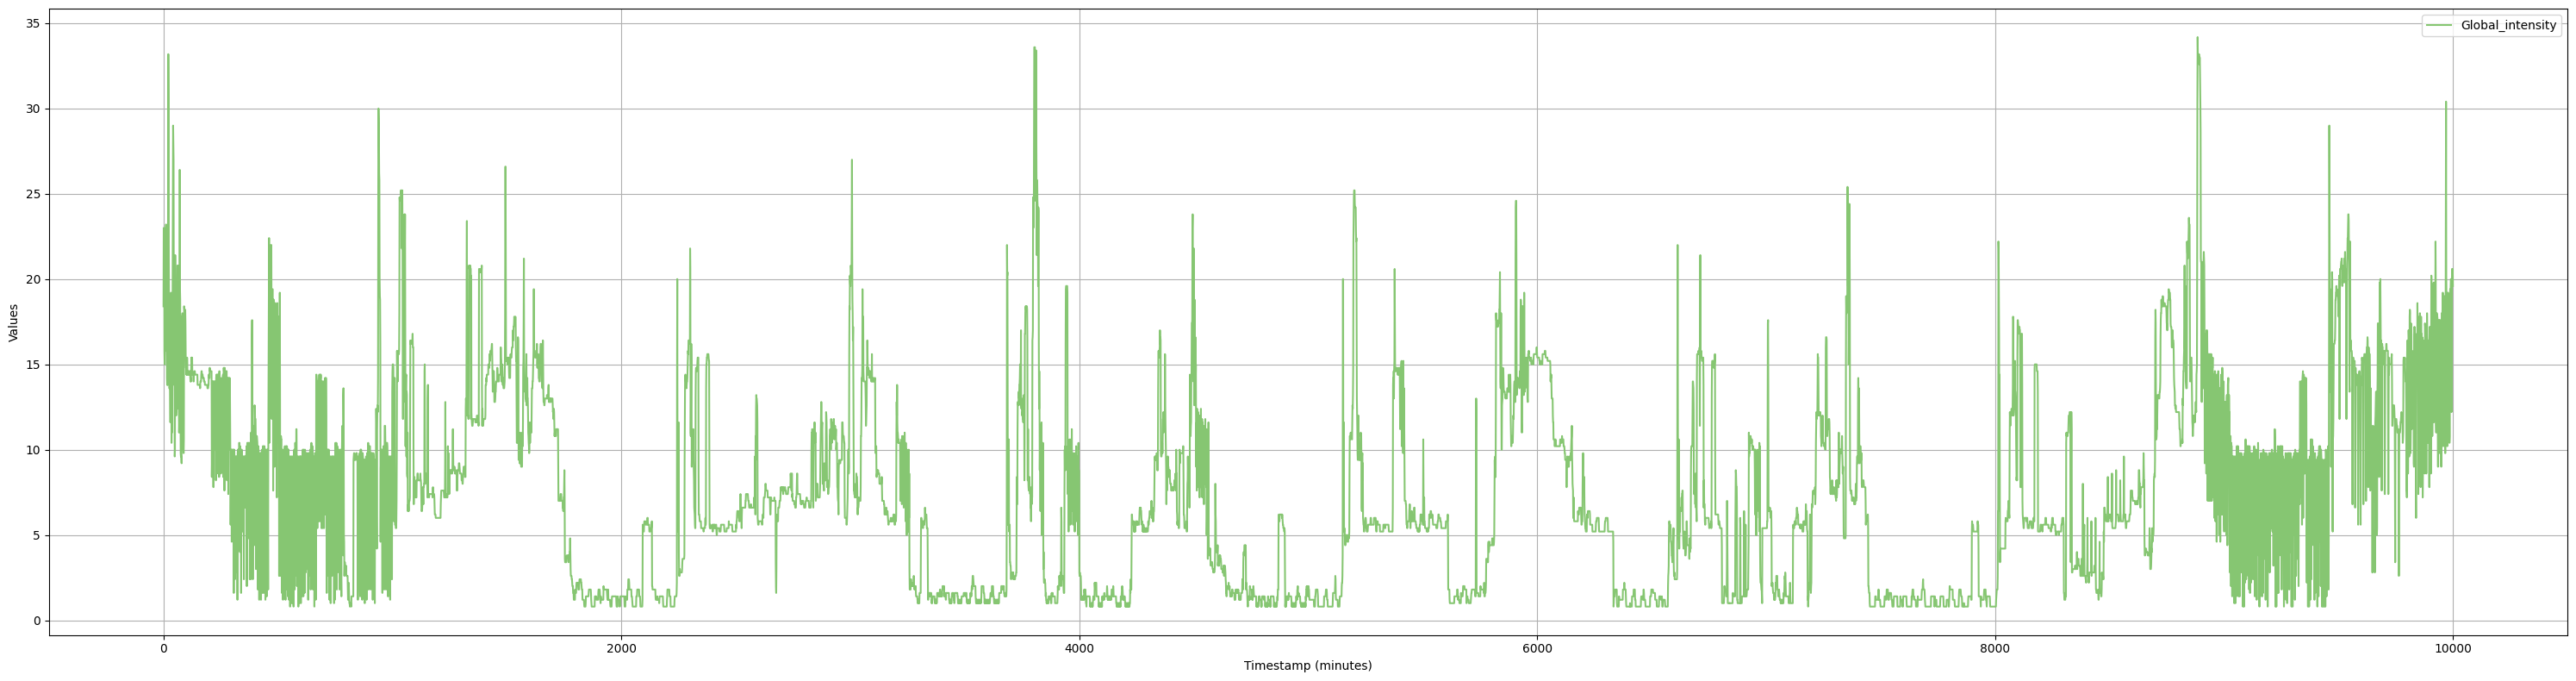

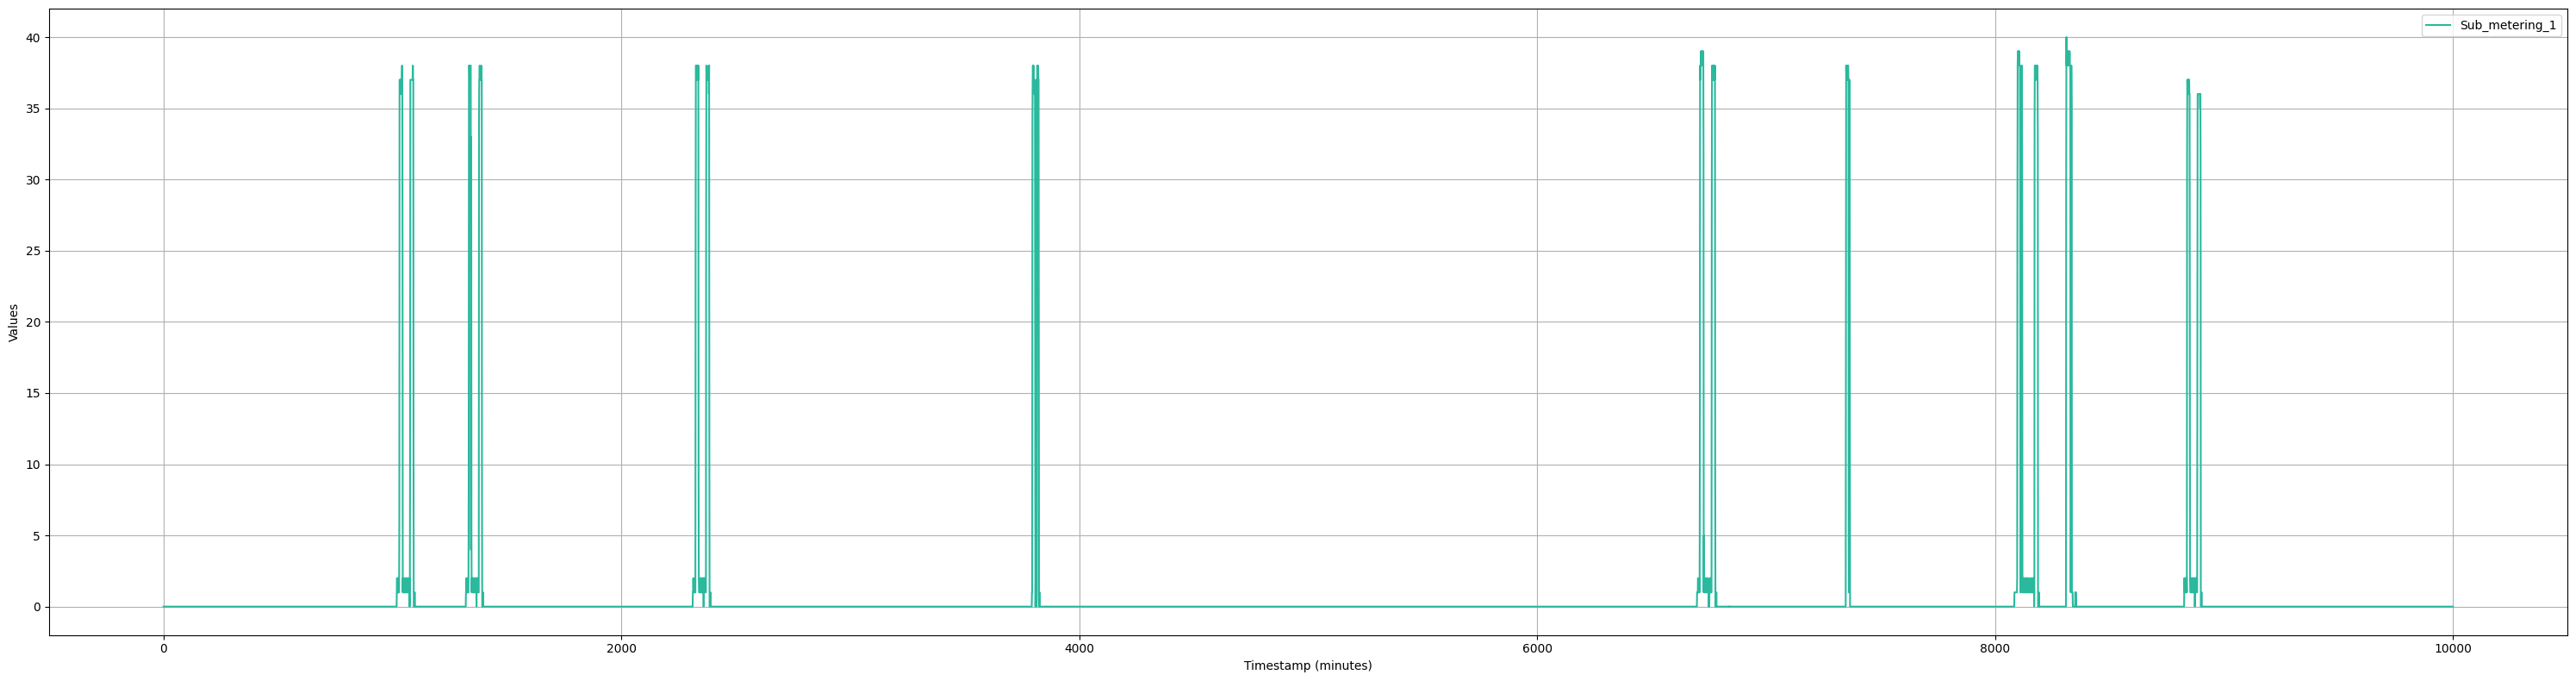

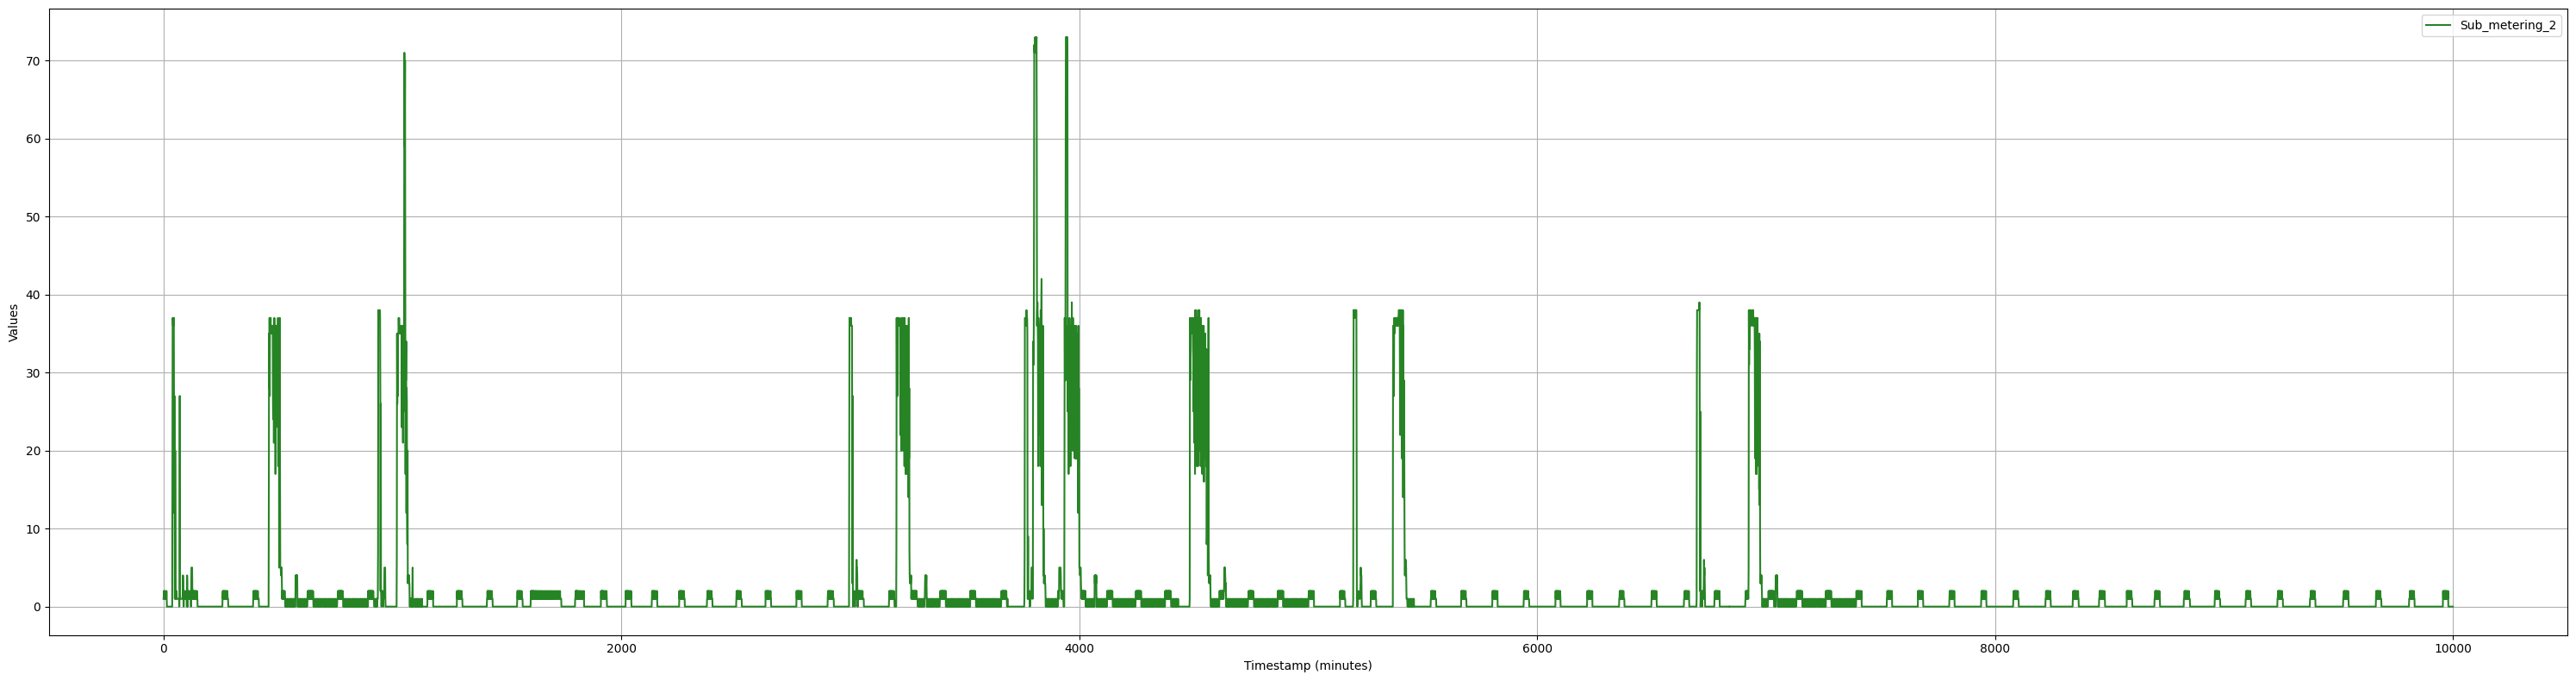

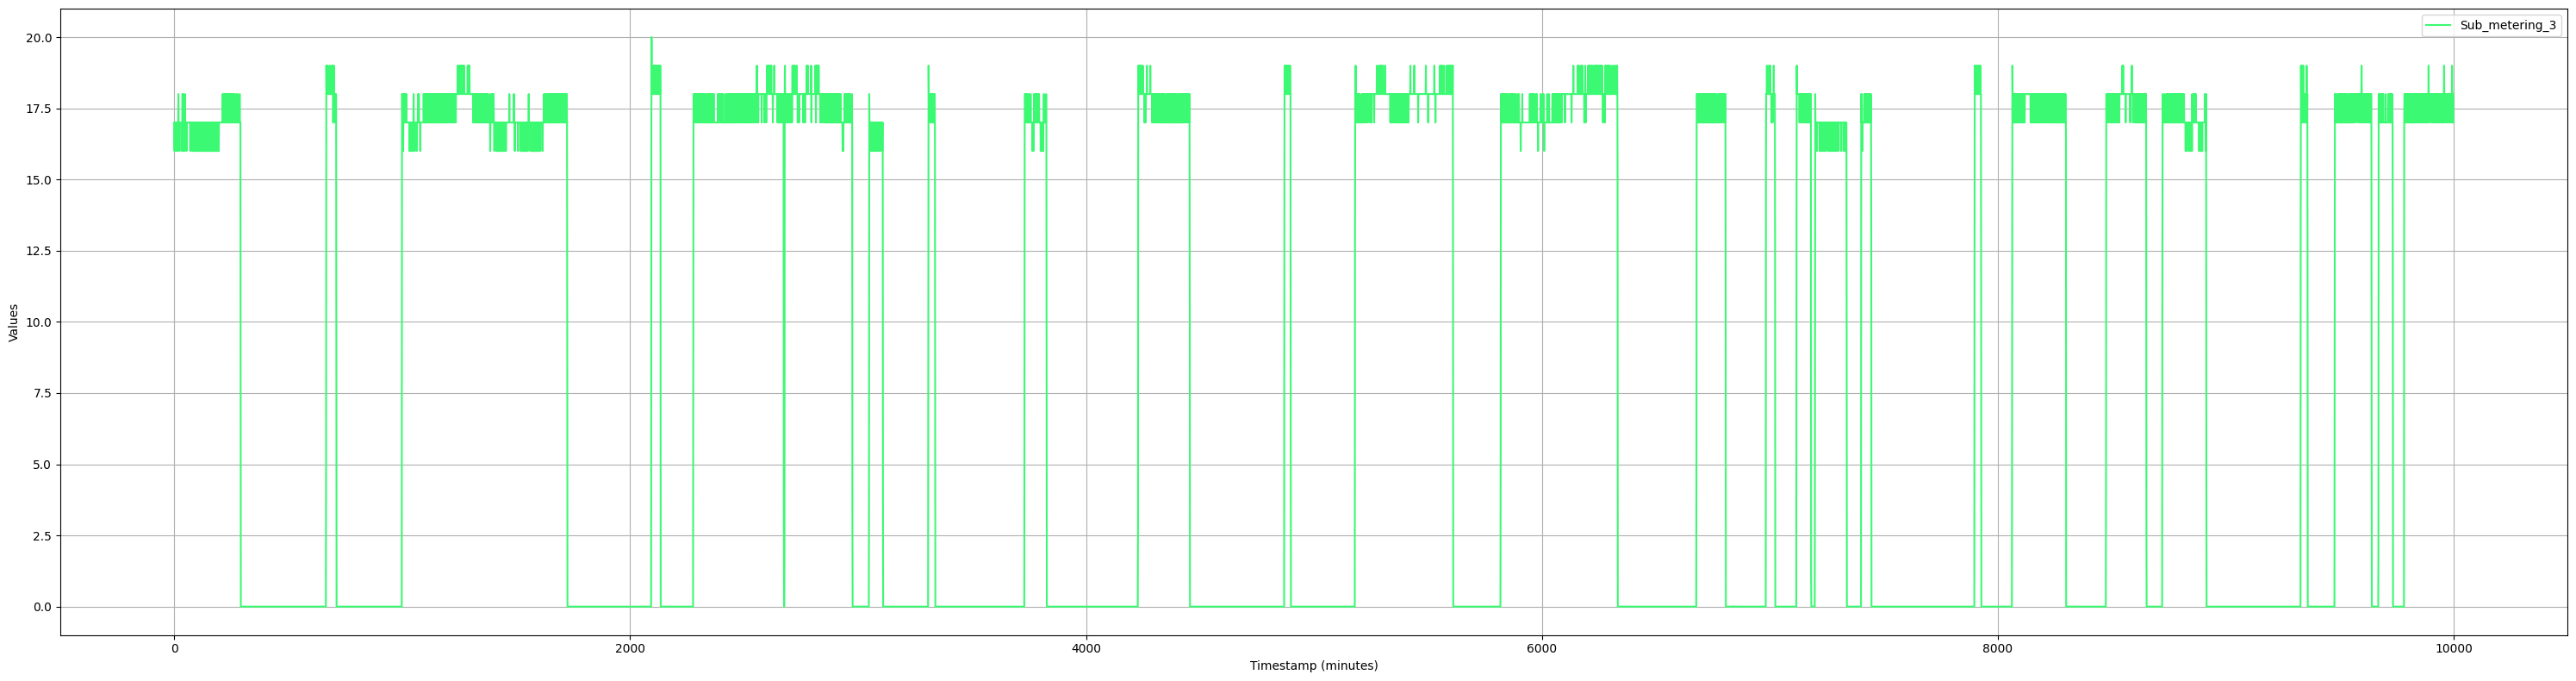

In [75]:
plot_timeseries(data, 'Timestamp', minute_limit=10000)

Možemo da primetimo da postoji dosta šuma među podacima.

## Trening NN modela nad originalnim podacima

In [76]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim

In [77]:
def prepare_data(X_data, y_data, train_minutes, validation_steps):
    X, y = [], []
    for i in range(len(X_data) - train_minutes - validation_steps):
        X.append(X_data[i:i + train_minutes])
        y.append(y_data[i + train_minutes:i + train_minutes + validation_steps])
    return np.array(X), np.array(y)

In [78]:
minutes_train = 2000
train_data = data.head(minutes_train)
train_data.drop(labels=['Timestamp'],axis=1, inplace=True)
train_y = train_data[['Global_active_power']]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(train_data)
train_y = scaler.fit_transform(train_y)

C:\Users\Danilo\AppData\Local\Temp\ipykernel_12172\514601177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(labels=['Timestamp'],axis=1, inplace=True)


In [84]:
train_minutes = 60
validation_steps = 15
input_size = len(train_data[0])
hidden_layer_size = 50 
output_size = validation_steps
epochs = 50
batch_size = 16

In [80]:
X, y = prepare_data(train_data, train_y, train_minutes, validation_steps)

In [81]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [82]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # LSTM expects input shape (batch_size, seq_length, input_size)
        lstm_out, (hn, cn) = self.lstm(x)  # lstm_out shape: (batch_size, seq_length, hidden_size)
        
        # We are processing one sequence at a time (batch_size=1), so lstm_out will have shape (1, seq_length, hidden_size)
        # Take the last hidden state (last timestep)
        out = self.fc(lstm_out[:, -1, :])  # Shape: (1, hidden_size) -> pass to FC layer
        return out

In [ ]:
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (processing one sample at a time)
for epoch in range(epochs):
    model.train()
    
    for i in range(len(X_tensor)):
        # Get the current input sample and target
        batch_X = X_tensor[i].unsqueeze(0)  # Shape (1, train_minutes, 1)
        batch_y = y_tensor[i].unsqueeze(0)  # Shape (1, validation_steps)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)

        # Compute the loss
        loss = loss_function(predictions, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# 

Epoch 1/50, Loss: 5.540027632378042e-05
Epoch 2/50, Loss: 0.0017180698923766613
Epoch 3/50, Loss: 0.001852540299296379
Epoch 4/50, Loss: 0.0010192031040787697
Epoch 5/50, Loss: 0.001505321473814547
Epoch 6/50, Loss: 0.0011449981248006225
Epoch 7/50, Loss: 0.0010574812768027186
Epoch 8/50, Loss: 0.0005621987511403859
Epoch 9/50, Loss: 0.000597166595980525
Epoch 10/50, Loss: 0.0007161136600188911
Epoch 11/50, Loss: 0.0009614338632673025
Epoch 12/50, Loss: 0.0013577197678387165
Epoch 13/50, Loss: 0.000689926790073514
Epoch 14/50, Loss: 0.0005139207351021469
Epoch 15/50, Loss: 0.0008490237523801625
Epoch 16/50, Loss: 0.0008667787769809365
Epoch 17/50, Loss: 0.0003133283171337098
Epoch 18/50, Loss: 0.0003389210905879736
Epoch 19/50, Loss: 8.581520523875952e-05
Epoch 20/50, Loss: 5.076023444416933e-05
Epoch 21/50, Loss: 9.15241107577458e-05
Epoch 22/50, Loss: 0.00017002229287754744
Epoch 23/50, Loss: 0.0001227461325470358
Epoch 24/50, Loss: 0.00031510493136011064
Epoch 25/50, Loss: 7.8550518

IndexError: too many indices for tensor of dimension 2

In [89]:
model.eval()
with torch.no_grad():
    # Choose a validation sample (e.g., the last sample in the dataset)
    validation_input = torch.tensor(train_data[-train_minutes:], dtype=torch.float32).unsqueeze(0)  # (1, train_minutes, 1)
    
    predicted_power_usage = model(validation_input)
    
    # Rescale the prediction to original scale
    predicted_power_usage_rescaled = scaler.inverse_transform(predicted_power_usage.numpy().reshape(-1, 1))

    print("Predicted power usage for the next 10 time steps:", predicted_power_usage_rescaled)

Predicted power usage for the next 10 time steps: [[0.26740777]
 [0.26903313]
 [0.26845878]
 [0.26841742]
 [0.26940158]
 [0.26861325]
 [0.26978457]
 [0.27039513]
 [0.2683557 ]
 [0.26771227]
 [0.26797497]
 [0.26957083]
 [0.26896963]
 [0.2704195 ]
 [0.26637128]]
